In [4]:
"""
Phase 3: Apply Unsupervised Learning - Clustering on Stroke Dataset

Justification for Algorithm Selection:

K-Means clustering was chosen due to its effectiveness and simplicity for structured datasets like medical records,
 where the goal is to identify distinct groups based on patient characteristics (e.g., age, health conditions).
 It performs well when clusters are relatively spherical and of similar size.

DBSCAN was selected as a complementary method because it can detect clusters of arbitrary shapes and handle noise points (outliers), which may exist in medical datasets.
 Using both algorithms allows us to compare and understand the strengths and limitations of different clustering approaches in this context.
"""

# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from google.colab import drive


In [5]:
# Step 2: Load dataset from Google Drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Dataset/Preprocessed_Healthcare_Data.csv"
data = pd.read_csv(file_path)
print("Dataset loaded successfully!")

# Step 3: Prepare data by removing the target label
data_clustering = data.drop(columns=['stroke'])

# Step 4: Normalize data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_clustering)


Mounted at /content/drive
Dataset loaded successfully!


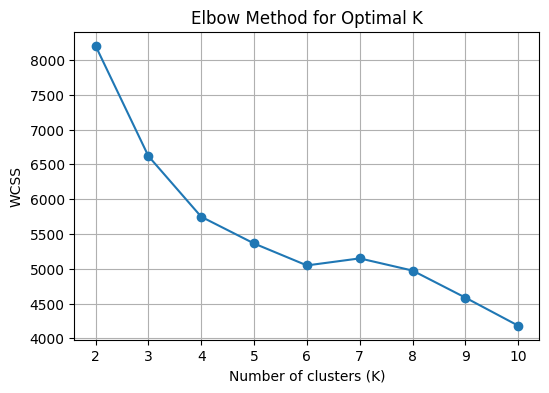

Silhouette Coefficient (K-Means): 0.1856


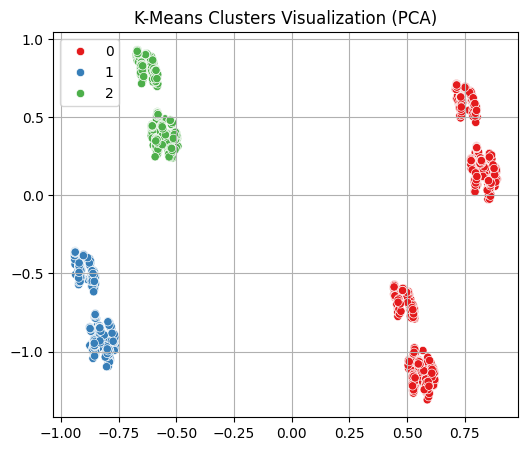

In [6]:
# Step 5: Apply K-Means Clustering for different K values
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Visualize Elbow Method
plt.figure(figsize=(6,4))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Apply K-Means with optimal K = 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
kmeans_labels = kmeans.labels_

# Evaluate K-Means
silhouette_kmeans = silhouette_score(data_scaled, kmeans_labels)
print(f"Silhouette Coefficient (K-Means): {silhouette_kmeans:.4f}")

# Visualize K-Means clusters using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
plt.figure(figsize=(6,5))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=kmeans_labels, palette='Set1')
plt.title('K-Means Clusters Visualization (PCA)')
plt.grid(True)
plt.show()


Silhouette Coefficient (DBSCAN): 0.6723


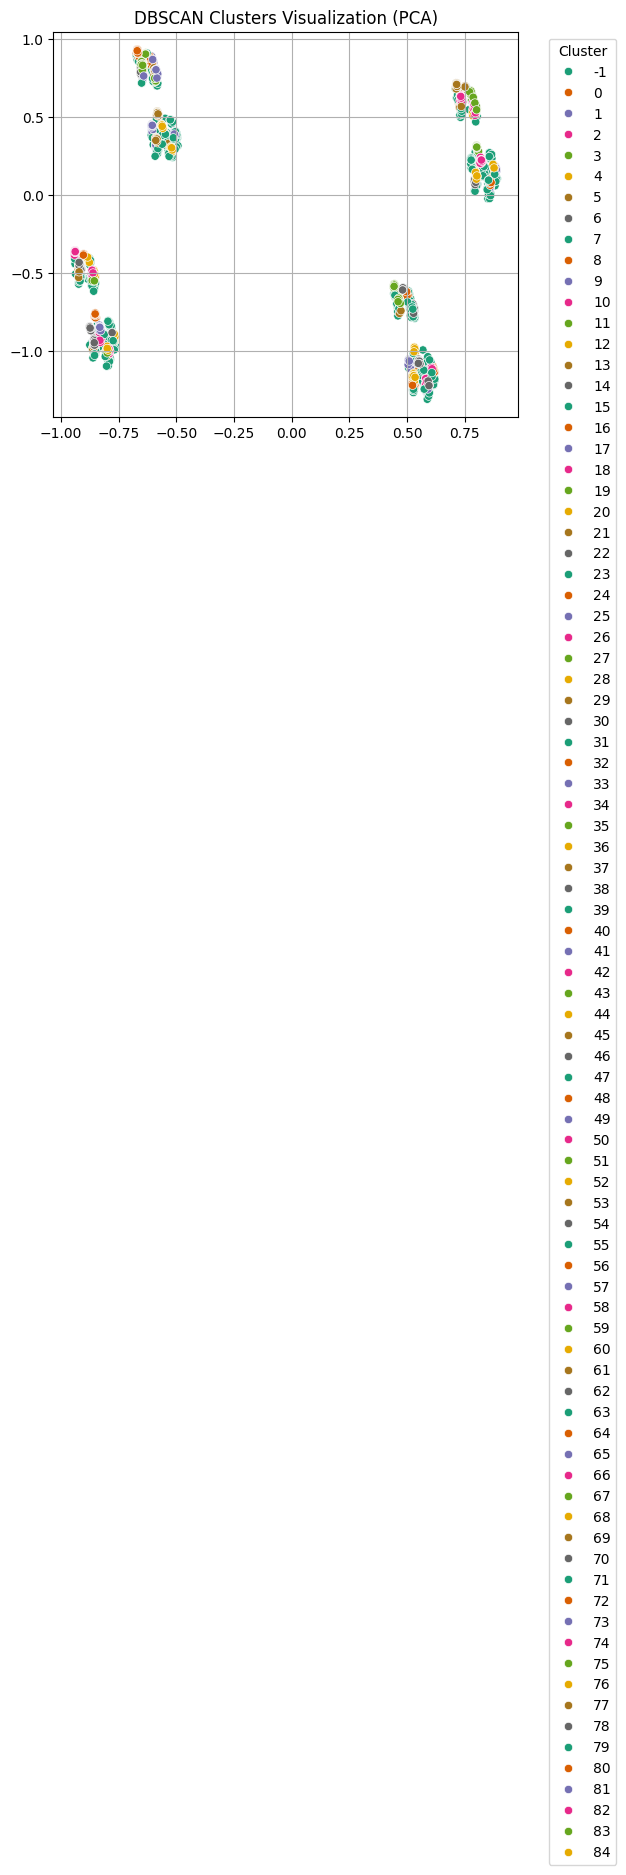

In [13]:
# Step 6: Apply DBSCAN (with tuned parameters)
dbscan = DBSCAN(eps=0.8, min_samples=8)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Filter out noise points for silhouette score
mask = dbscan_labels != -1
if np.sum(mask) > 0:
    silhouette_dbscan = silhouette_score(data_scaled[mask], dbscan_labels[mask])
    print(f"Silhouette Coefficient (DBSCAN): {silhouette_dbscan:.4f}")
else:
    print(" All points were labeled as noise (-1) by DBSCAN. Try adjusting eps/min_samples.")

# Visualize DBSCAN Clusters
plt.figure(figsize=(6,5))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=dbscan_labels, palette='Dark2', legend='full')
plt.title('DBSCAN Clusters Visualization (PCA)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



In [12]:
# Step 7: Custom BCubed Precision & Recall function
def bcubed_precision_recall(true_labels, cluster_labels):
    n = len(true_labels)
    precision_sum = 0
    recall_sum = 0
    for i in range(n):
        for j in range(n):
            same_cluster = (cluster_labels[i] == cluster_labels[j])
            same_class = (true_labels[i] == true_labels[j])
            if same_cluster:
                precision_sum += same_class
            if same_class:
                recall_sum += same_cluster
    precision = precision_sum / sum([sum(cluster_labels == cluster_labels[i]) for i in range(n)])
    recall = recall_sum / sum([sum(true_labels == true_labels[i]) for i in range(n)])
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    return precision, recall, f1

# Step 8: Evaluate both models using BCubed metrics
true_labels = data['stroke'].values

# K-Means
precision_kmeans, recall_kmeans, fscore_kmeans = bcubed_precision_recall(true_labels, kmeans_labels)
print(f"BCubed Precision (K-Means): {precision_kmeans:.4f}")
print(f"BCubed Recall (K-Means): {recall_kmeans:.4f}")
print(f"BCubed F1-Score (K-Means): {fscore_kmeans:.4f}")

# DBSCAN (excluding noise points)
mask = dbscan_labels != -1
precision_dbscan, recall_dbscan, fscore_dbscan = bcubed_precision_recall(true_labels[mask], dbscan_labels[mask])
print(f"BCubed Precision (DBSCAN): {precision_dbscan:.4f}")
print(f"BCubed Recall (DBSCAN): {recall_dbscan:.4f}")
print(f"BCubed F1-Score (DBSCAN): {fscore_dbscan:.4f}")

# Step 9: Explain usage
def explain_usage():
    explanation = """
    The generated clusters help identify groups of patients with similar health profiles.

    How clusters can improve recommendations:
    1. Each cluster may represent a unique patient segment.
    2. Recommendations can be tailored to these segments.
    3. Clusters could be used as features in the supervised model.
    """
    print(explanation)

explain_usage()

# Conclusion
print("\n Both K-Means and DBSCAN were implemented and evaluated.")
print("K-Means produced clearer clusters and can support improving recommendations in healthcare.")


BCubed Precision (K-Means): 0.8924
BCubed Recall (K-Means): 0.3838
BCubed F1-Score (K-Means): 0.5368
BCubed Precision (DBSCAN): 0.9237
BCubed Recall (DBSCAN): 0.0270
BCubed F1-Score (DBSCAN): 0.0524

    The generated clusters help identify groups of patients with similar health profiles.

    How clusters can improve recommendations:
    1. Each cluster may represent a unique patient segment.
    2. Recommendations can be tailored to these segments.
    3. Clusters could be used as features in the supervised model.
    

 Both K-Means and DBSCAN were implemented and evaluated.
K-Means produced clearer clusters and can support improving recommendations in healthcare.


In [15]:
# Summary and Final Decision:
# Both K-Means and DBSCAN were applied to cluster the dataset.
# K-Means outperformed DBSCAN with higher silhouette and BCubed F1-Score.
# Therefore, K-Means is recommended to enhance recommendation systems or integrate into future supervised models.